# Manipulate waveform decomposition frame and find corotating angles

### Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
from matplotlib.pyplot import *
# Import needed packages from positive
from positive.plotting import sYlm_mollweide_plot
from positive import alert
# Import other usefuls
from os.path import expanduser
from nrutils import scsearch,gwylm
from nrutils.core.basics import *
from numpy import *

(positive)>> Applying custom matplotlib settings.


### Find a simulation

In [144]:
# A = scsearch(institute='bam',keyword='q1.2_dqdcp2',verbose=True)
A = scsearch(institute='bam',keyword='q2_a10_a28_ph0_th90',verbose=True)
# A = scsearch(institute='gt',keyword='Sq4_d9_a0.6_oth.090_rr_M140',verbose=True)
# A = scsearch(q=1,keyword='hrq',verbose=True)
# A = scsearch(precessing=True,verbose=True)
# A = scsearch(keyword='EP_um2D10_d6_sz-n88')

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found keyword (=q2_a10_a28_ph0_th90) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 2 possibly degenerate simulations:
[0001][hogshead] chinmay_precessingRuns: 1chi0.80-2chi76.37-p-q2.00	(q2_a10_a28_ph0_th90_80_Points)
[0002][hogshead] chinmay_precessingRuns: 1chi0.80-2chi76.37-p-q2.00	(q2_a10_a28_ph0_th90)



### Load waveform data

In [202]:
y = gwylm( A[0], lmax=2, clean=True )
# y = gwylm( A[0], lm=[(2,2),(2,1),(2,0)], clean=False )

# simdir = '/Users/book/MOUNT/tmp/mnt/hogshead/NR_data/ReducedData-hogshead/q2/q2a04t90dPm1_T_96_408/'
# y = gwylm( simdir, lmax=2, clean=True )

([<matplotlib.axes._subplots.AxesSubplot at 0x1c26e177d0>,
 <matplotlib.figure.Figure at 0x1116344d0>)

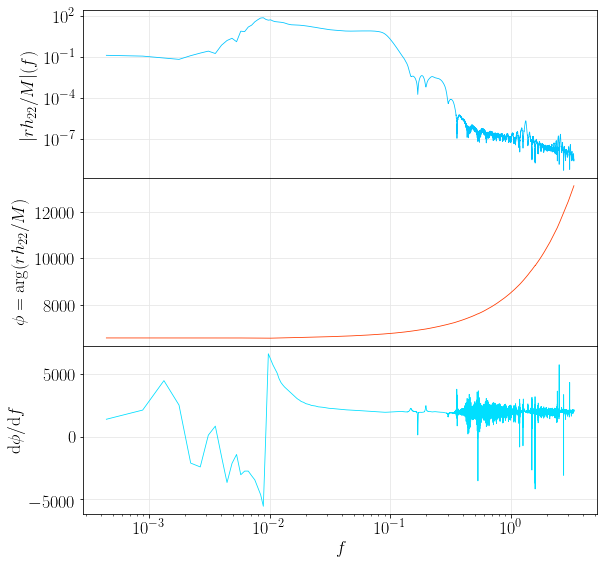

In [203]:
y.lm[2,2]['strain'].plot(domain='freq')

### Try to calculate corotating angles

In [235]:

# Options
kind = 'psi4'
domain = 'time'

# Construct dictionary of multipoles using all multipoles available
mp = { (l,m) : ( y.lm[l,m][kind].y if domain in ('t','time') else y.lm[l,m][kind].fd_y ) for l,m in y.lm  }
domain_vals = y.lm[2,2][kind].t if domain in ('t','time') else y.lm[2,2][kind].f

# Calculate corotating angles using low-level function
alpha,beta,gamma = calc_coprecessing_angles( mp, domain_vals )
x,yy,z            = calc_coprecessing_angles( mp, domain_vals, return_xyz=True )


### Plot the angles and the waveform amplitude for reference

(599.25, 2098.7999999999997)

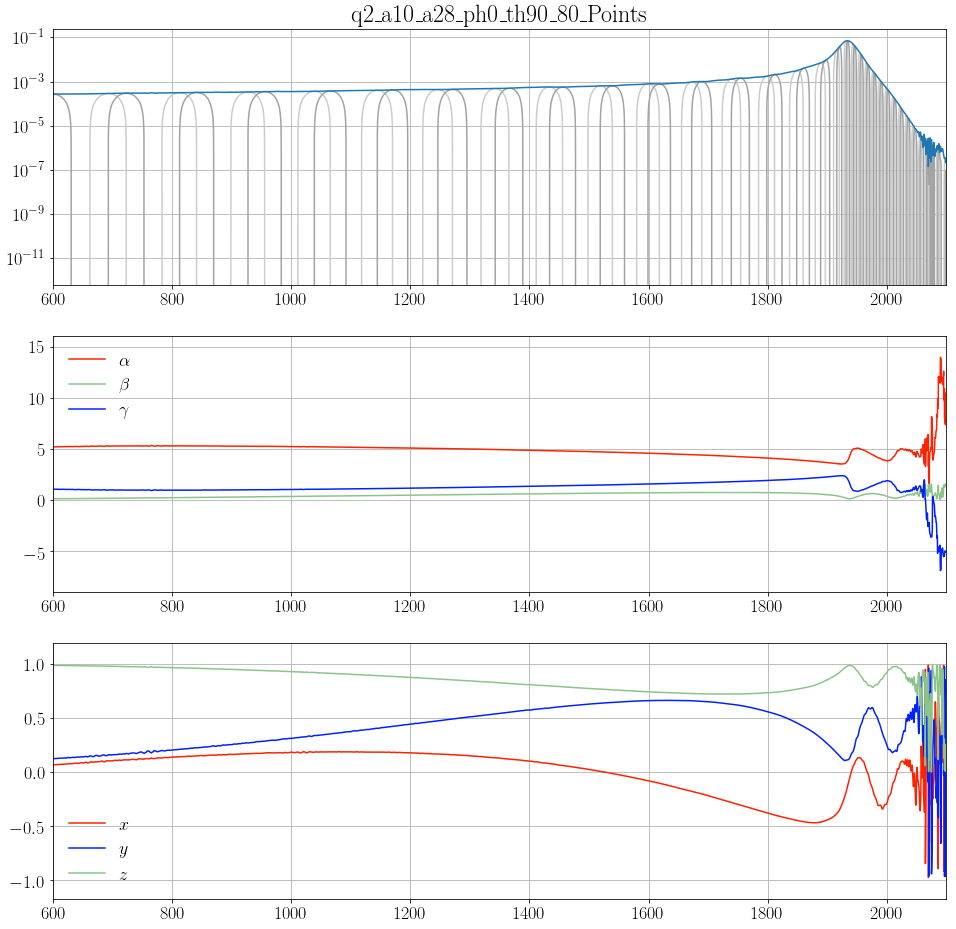

In [236]:

#
fig = figure( figsize=4*figaspect(1) )
clr = rgb(3,jet=True); grey = ones(3)*0.8
lw = 1.5

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#
mask = (domain_vals>=domain_min) & (domain_vals<=domain_max)

#
ax = subplot(3,1,1)
title( y.simname.replace('_','\_') )
if domain in ('t','time'):
    plot( domain_vals, y.lm[2,2][kind].plus, color=grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].cross, color=0.8*grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].amp, linewidth = lw )
    yscale('log',nonposy='clip')
else:
    plot( domain_vals, y.lm[2,2][kind].fd_amp, linewidth = lw )
    xscale('log'); yscale('log')
    ylim( lim(y.lm[2,2][kind].fd_amp[mask]) )
grid()

#
subplot(3,1,2,sharex=ax)
reshift = lambda V: V - V[mask][0] + mod(V[mask][0],2*pi)
plot( domain_vals, reshift(alpha), color = clr[0], linewidth = lw, label=r'$\alpha$' )
plot( domain_vals, reshift(beta),  color = clr[1], linewidth = lw, label=r'$\beta$' )
plot( domain_vals, reshift(gamma), color = clr[2], linewidth = lw, label=r'$\gamma$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([reshift(alpha)[mask],reshift(beta)[mask],reshift(gamma)[mask]]), dilate=0.1 ) )
grid()

#
subplot(3,1,3,sharex=ax)
plot( domain_vals, x, color = clr[0], linewidth = lw, label=r'$x$' )
plot( domain_vals, yy,  color = clr[2], linewidth = lw, label=r'$y$' )
plot( domain_vals, z, color = clr[1], linewidth = lw, label=r'$z$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([x[mask],yy[mask],z[mask]]), dilate=0.1 ) )
grid()

#
ax.set_xlim( [ domain_min, domain_max ] )

## Plot XY Projection of angles in polar coordinates

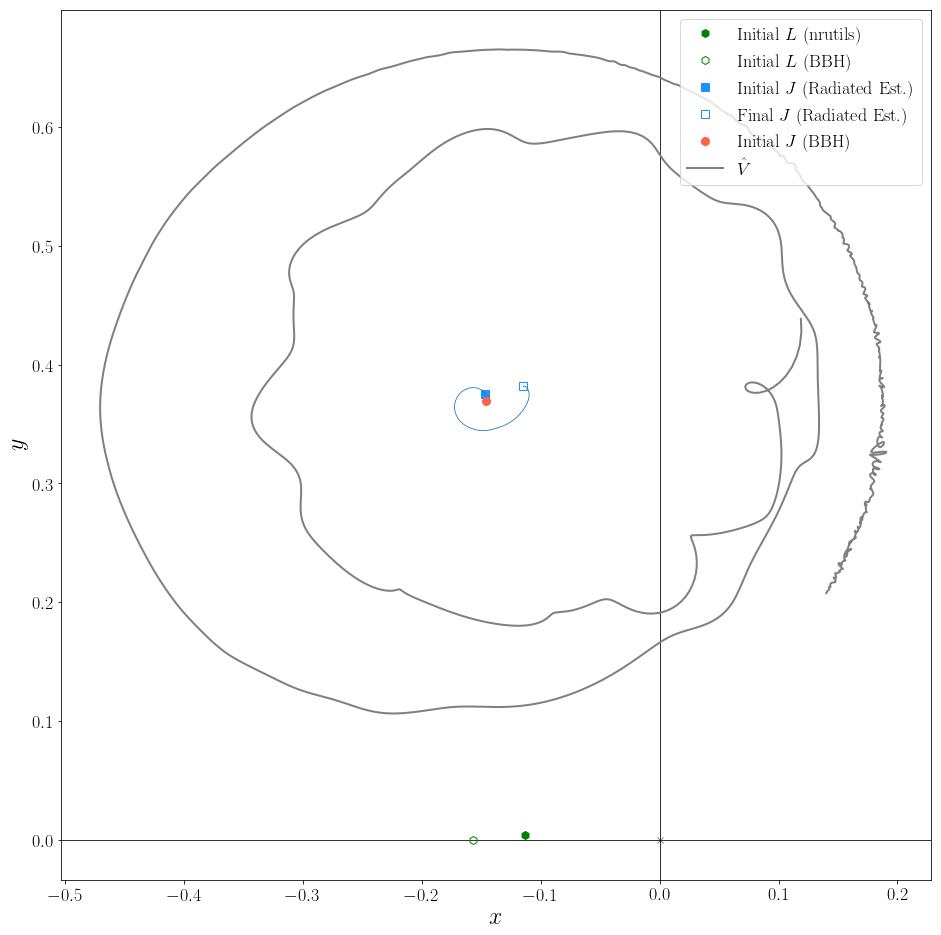

In [238]:

#
fig = figure( figsize=4*figaspect(1) )
color = rgb(3)

#
y.__calc_radiated_quantities__()
k = 0
jx,jy,jz = y.remnant['J'][k] / linalg.norm( y.remnant['J'][k] )
jfx,jfy,jfz = y.remnant['J'][-1] / linalg.norm( y.remnant['J'][-1] )

#
lx,ly,lz = (y.L1+y.L2)/linalg.norm( y.L1+y.L2 )
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
lx_bbh,ly_bbh,lz_bbh = L/linalg.norm(L)

#
S1 = array([ y.raw_metadata.initial_bh_spin2x, y.raw_metadata.initial_bh_spin2y, y.raw_metadata.initial_bh_spin2z])
S2 = array([ y.raw_metadata.initial_bh_spin1x, y.raw_metadata.initial_bh_spin1y, y.raw_metadata.initial_bh_spin1z])
S = S1+S2
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
bbh_jx,bbh_jy,bbh_jz = (L+S)/linalg.norm( L+S )

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#
mask = (domain_vals>=domain_min) & (domain_vals<=2030)
mask = smoothest_part(alpha, smoothness_radius=120, smoothness_stepsize=3, smooth_length=3, smoothness_tolerance=2, unsigned=True)

#
axhline(0,color='k')
axvline(0,color='k')

#
plot( lx,ly, 'h', color='green', label='Initial $L$ (nrutils)', ms=8 )
plot( lx_bbh,ly_bbh, 'h', color='green', label='Initial $L$ (BBH)', ms=8, mfc='none' )

#
plot( jx,jy, 's', color='dodgerblue', label='Initial $J$ (Radiated Est.)', ms=8 )
plot( jfx,jfy, 's', mfc='none', color='dodgerblue', label='Final $J$ (Radiated Est.)', ms=8 )

#
plot( bbh_jx,bbh_jy, 'o', color='tomato', label='Initial $J$ (BBH)', ms=8 )

#
plot( 0,0, 'xk', alpha=0.5 )

#
plot( x[mask],yy[mask], lw=2, color='grey', label='$\hat{V}$' )

#
J = y.remnant['J']
for k in range(J.shape[0]):
    J[k,:] /= linalg.norm(J[k,:])
plot( J[:,0],J[:,1] )

axis('square');

#
xlabel('$x$')
ylabel('$y$');

#
legend( loc=1, frameon=True )
